In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import sys
from pathlib import Path
# from my_kalman_filter import * 

# Extract manually input data from Excel

In [127]:
path = './data'

def list_files_with_extension(directory, extension):
    return [str(f) for f in Path(directory).glob(f'*{extension}') if f.is_file()]

In [128]:
excel_files = list_files_with_extension(path, '.xlsx')
if excel_files:
    excel_file = excel_files[0]
    df_excel = pd.read_excel(excel_file, sheet_name='All_Data')
else:
    df_excel = None

df_excel_clean = df_excel.copy()
df_excel_clean = df_excel_clean.rename(columns={"Condition": "condition", "V_housing": "Vhousing", "T_housing": "T_thermocouple",})

In [129]:
df_excel_clean

,T_thermocouple,Vhousing,condition
0,27.0,792,Open - heating
1,28.1,801,Open - heating
2,29.0,805,Open - heating
3,30.0,815,Open - heating
4,31.0,824,Open - heating
...,...,...,...
57,38.1,915,50C
58,39.2,926,50C
59,40.1,938,50C
60,41.1,946,50C


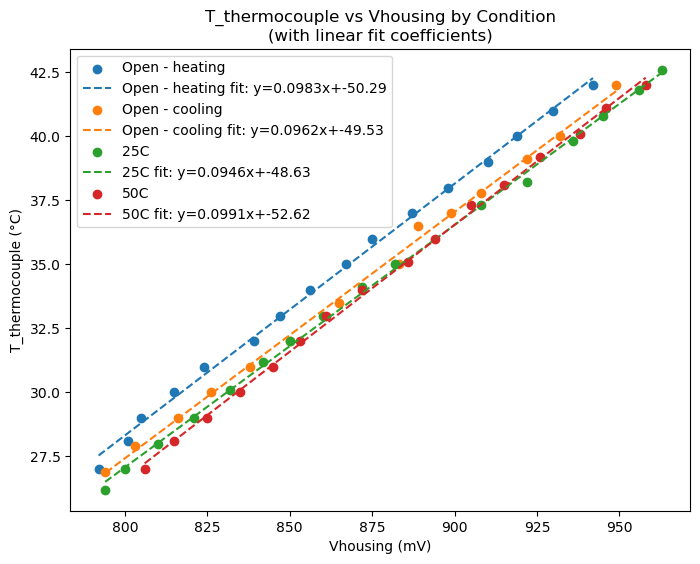

In [130]:
plt.figure(figsize=(8, 6))
colors = {'50°C': 'tab:blue', '25°C': 'tab:orange', 'OPEN': 'tab:green'}
unique_conditions = df_excel_clean['condition'].unique()

for cond in unique_conditions:
    mask = df_excel_clean['condition'] == cond
    x = df_excel_clean.loc[mask, 'Vhousing']
    y = df_excel_clean.loc[mask, 'T_thermocouple']
    plt.scatter(x, y, label=cond, color=colors.get(cond, None))
    # Linear regression for this condition
    if len(x) > 1:
        model = LinearRegression()
        model.fit(x.values.reshape(-1, 1), y.values)
        slope = model.coef_[0]
        intercept = model.intercept_
        plt.plot(x, model.predict(x.values.reshape(-1, 1)), color=colors.get(cond, None), linestyle='--',
                 label=f"{cond} fit: y={slope:.3g}x+{intercept:.2f}")

# # Linear regression for all data
# x_all = df_excel_clean['Vhousing'].values.reshape(-1, 1)
# y_all = df_excel_clean['T_thermocouple'].values
# model_all = LinearRegression()
# model_all.fit(x_all, y_all)
# slope_all = model_all.coef_[0]
# intercept_all = model_all.intercept_
# plt.plot(df_excel_clean['Vhousing'], model_all.predict(x_all), color='k', linestyle='--',
#          label=f"All data fit: y={slope_all:.3g}x+{intercept_all:.2f}")

plt.xlabel('Vhousing (mV)')
plt.ylabel('T_thermocouple (°C)')
plt.legend()
plt.title('T_thermocouple vs Vhousing by Condition\n(with linear fit coefficients)')
plt.show()

In [131]:
# Mask for 'OPEN' condition in df_excel_clean
mask_open = df_excel_clean['condition'] == 'Open - heating'
x_open = df_excel_clean.loc[mask_open, 'Vhousing'].values.reshape(-1, 1)
y_open = df_excel_clean.loc[mask_open, 'T_thermocouple'].values

# Fit linear regression for OPEN data
model_open = LinearRegression()
model_open.fit(x_open, y_open)
slope_open = model_open.coef_[0]
intercept_open = model_open.intercept_

# Import the Display Readings

In [134]:
def extract_data_inline(filename):
    """
    Extract data from a text file generated by makerplot or equivalent, adapted for your column structure.
    Args:
        filename: The text file containing the data to extract.
    Returns:
        idx_start: Index of start of burn.
        idx_stop: Index of stop of burn.
        delta_time: Median time difference between records.
        T : DataFrame of temperatures.
        X : DataFrame of voltages and other signals.
    """
    data = pd.read_table(filename, delimiter=',')
    
    # Identify start and stop indices for the burn using 'power_flag'
    idx_start = np.where(np.diff(np.insert(data['power_flag'].values, 0, 0)) == 1)[0].tolist()
    idx_stop = np.where(np.diff(np.append(data['power_flag'].values, 0)) == -1)[0].tolist()
    
    # Extract voltages and other signals
    V_rad_short = data['V_radshort'].to_numpy()
    V_rad_tot = data['V_radtotal'].to_numpy()
    V_housing = data['V_housing'].to_numpy()
    V_diode = data['V_diode'].to_numpy()
    V_spike = data['VTC2'].to_numpy()
 
    
    # Cooling flags
    cooling_flag_1 = data['antenna_cooling_flag'].to_numpy() if 'antenna_cooling_flag' in data.columns else [float('nan')] * len(data)
    cooling_flag_2 = data['switch_cooling_flag'].to_numpy() if 'switch_cooling_flag' in data.columns else [float('nan')] * len(data)
    # print(data.Time)
    power = data['Power'].to_numpy() * (data['power_flag'] > 0).astype(float)

    delta_time = np.median(np.diff(data['Time'].astype(float).values))
    
    # Temperatures (using VTC2 as T_housing, V_diode as T_diode, V_probe as T_display)
    T = pd.DataFrame({
        'T_antenna': [float('nan')] * len(data),  # Not available in your columns
        'T_diode': V_diode,
        'T_housing': data['VTC2'].to_numpy(),
        'T_display': data['V_probe'].to_numpy()
    })
    
    X = pd.DataFrame({
        'V_rad_short': V_rad_short,
        'V_rad_tot': V_rad_tot,
        'V_housing': V_housing,
        'V_diode': V_diode,
        'V_spike': V_spike,
        'cooling_flag_1': cooling_flag_1,
        'cooling_flag_2': cooling_flag_2,
        'power': power
    })
    
    return idx_start, idx_stop, delta_time, T, X

In [135]:
txt_files = list_files_with_extension(path, '.txt')

In [136]:
# Add a 'time_index' column before concatenating all_X
all_X = []

for file in txt_files:
    # Extract condition (text after last underscore, before .txt)
    condition = Path(file).stem.split('_')[-1]
    # Extract data
    _, _, _, _, X_local = extract_data_inline(file)
    # Drop unwanted columns
    X_local = X_local.drop(columns=['cooling_flag_1', 'cooling_flag_2', 'power'])
    # Add time_index column
    X_local = X_local.copy()
    X_local['time_index'] = X_local.index
    # Add condition column
    X_local['condition'] = condition
    all_X.append(X_local)

all_X = pd.concat(all_X, ignore_index=True)

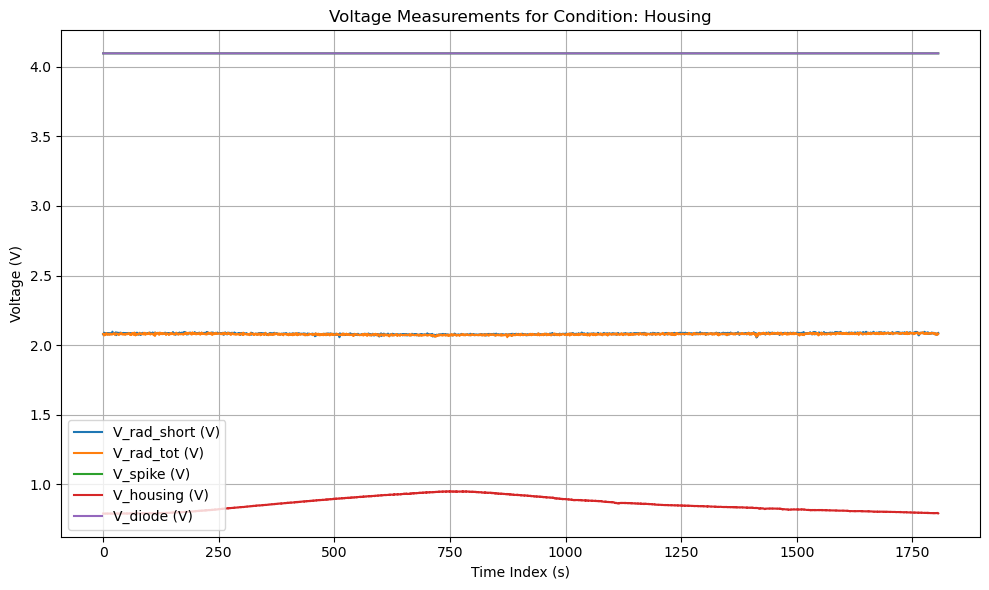

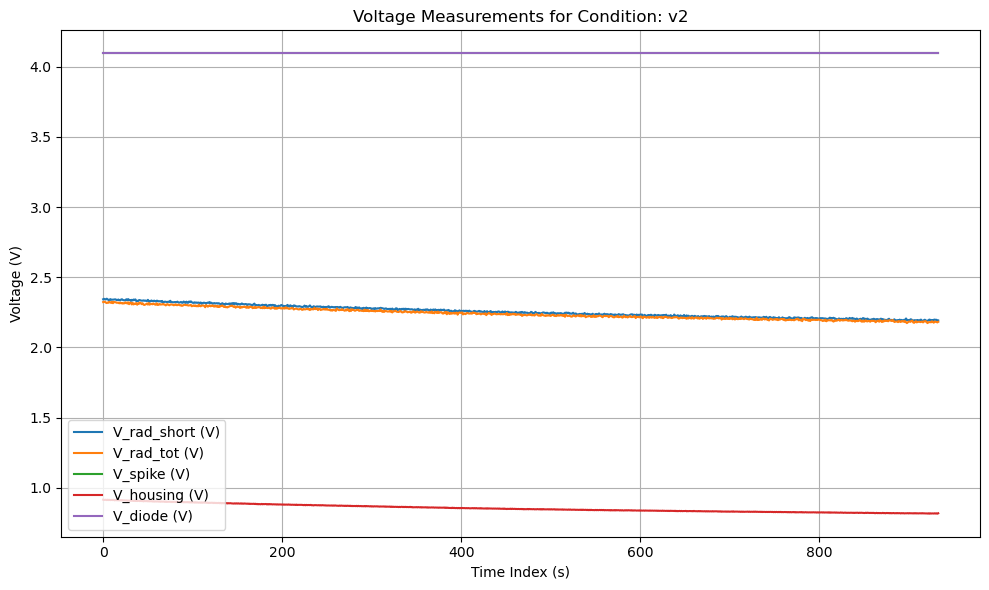

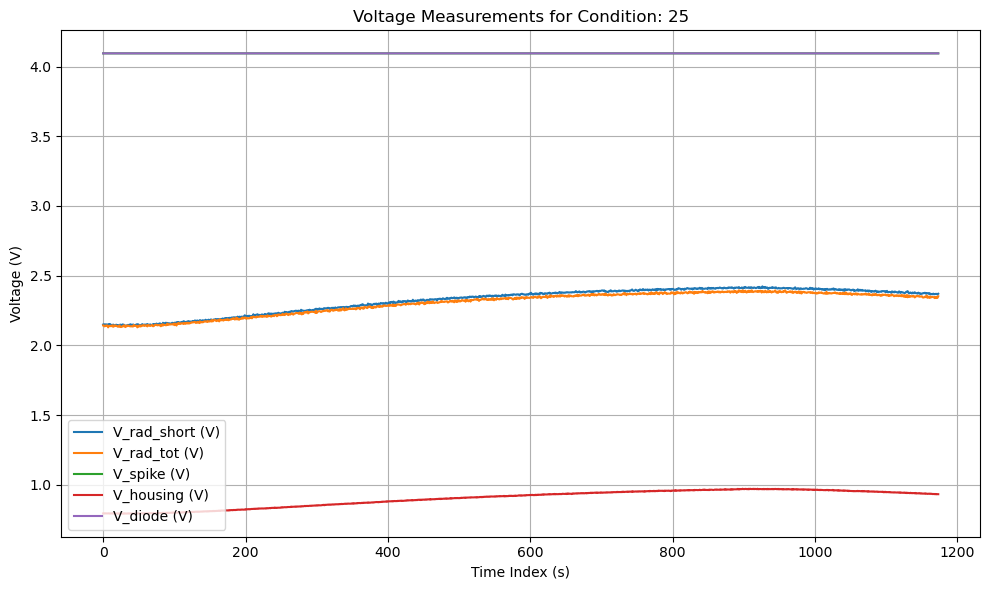

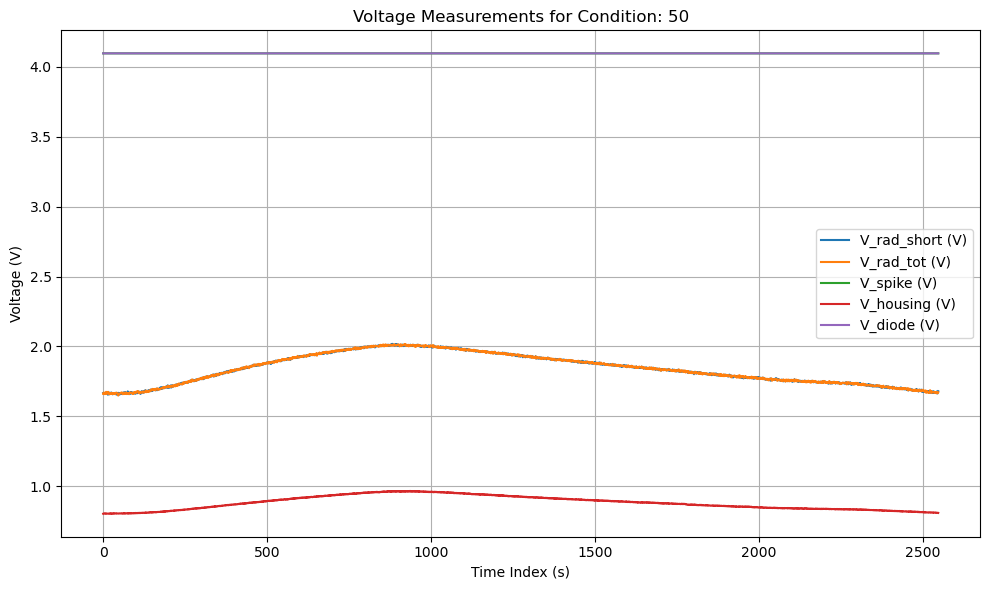

In [137]:
# Plot V_rad_short, V_rad_tot, V_spike, V_housing, V_diode vs sample index for each condition

variables = ['V_rad_short', 'V_rad_tot', 'V_spike', 'V_housing', 'V_diode']
labels = {
    'V_rad_short': 'V_rad_short (V)',
    'V_rad_tot': 'V_rad_tot (V)',
    'V_spike': 'V_spike (V)',
    'V_housing': 'V_housing (V)',
    'V_diode': 'V_diode (V)'
}

for cond in all_X['condition'].unique():
    subset = all_X[all_X['condition'] == cond]
    plt.figure(figsize=(10, 6))
    for var in variables:
        plt.plot(subset.time_index, subset[var] / 1000, label=labels[var])
    plt.title(f"Voltage Measurements for Condition: {cond}")
    plt.xlabel("Time Index (s)")
    plt.ylabel("Voltage (V)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Change the data in the different conditions to these updated conditions:
* the condition Housing with time index < 750 to open-heating
* the condition Housing with time index > 750 to open-cooling (restart the time index)
* the condition 25  with time index < 900 to 25C-heating
* the condition 25 with time index > 900 to 25C-cooling (restart time index)
* the condition v2 to 25C-cooling (concatenate time index with previous)
* the condition 50  with time index < 900 to 50C-heating
* the condition 50 with time index > 900 to 50C-cooling (restart time index)

In [165]:
# Copy all_X to avoid modifying the original
all_X_renamed = all_X.copy()

# 1. Housing
mask_housing = all_X_renamed['condition'].str.lower() == 'housing'
mask_housing_heating = mask_housing & (all_X_renamed['time_index'] < 750)
mask_housing_cooling = mask_housing & (all_X_renamed['time_index'] >= 750)

all_X_renamed.loc[mask_housing_heating, 'condition'] = 'open-heating'
all_X_renamed.loc[mask_housing_cooling, 'condition'] = 'open-cooling'
# Restart time_index for open-cooling
if mask_housing_cooling.any():
    idxs = all_X_renamed[mask_housing_cooling].index
    all_X_renamed.loc[idxs, 'time_index'] = range(len(idxs))

# 2. 25
mask_25c = all_X_renamed['condition'].str.lower() == '25'
mask_25c_heating = mask_25c & (all_X_renamed['time_index'] < 900)
mask_25c_cooling = mask_25c & (all_X_renamed['time_index'] >= 900)

all_X_renamed.loc[mask_25c_heating, 'condition'] = '25C-heating'
all_X_renamed.loc[mask_25c_cooling, 'condition'] = '25C-cooling'
# Restart time_index for 25C-cooling
if mask_25c_cooling.any():
    idxs = all_X_renamed[mask_25c_cooling].index
    all_X_renamed.loc[idxs, 'time_index'] = range(len(idxs))

# 3. v2 (concatenate to 25C-cooling)
mask_v2 = all_X_renamed['condition'].str.lower() == 'v2'
if mask_v2.any():
    # Find the last time_index of 25C-cooling
    last_cooling_idx = all_X_renamed.loc[all_X_renamed['condition'] == '25C-cooling', 'time_index'].max()
    idxs_v2 = all_X_renamed[mask_v2].index
    all_X_renamed.loc[idxs_v2, 'condition'] = '25C-cooling'
    all_X_renamed.loc[idxs_v2, 'time_index'] = range(last_cooling_idx + 1, last_cooling_idx + 1 + len(idxs_v2))

# 4. 50
mask_50c = all_X_renamed['condition'].str.lower() == '50'
mask_50c_heating = mask_50c & (all_X_renamed['time_index'] < 900)
mask_50c_cooling = mask_50c & (all_X_renamed['time_index'] >= 900)

all_X_renamed.loc[mask_50c_heating, 'condition'] = '50C-heating'
all_X_renamed.loc[mask_50c_cooling, 'condition'] = '50C-cooling'
# Restart time_index for 50C-cooling
if mask_50c_cooling.any():
    idxs = all_X_renamed[mask_50c_cooling].index
    all_X_renamed.loc[idxs, 'time_index'] = range(len(idxs))

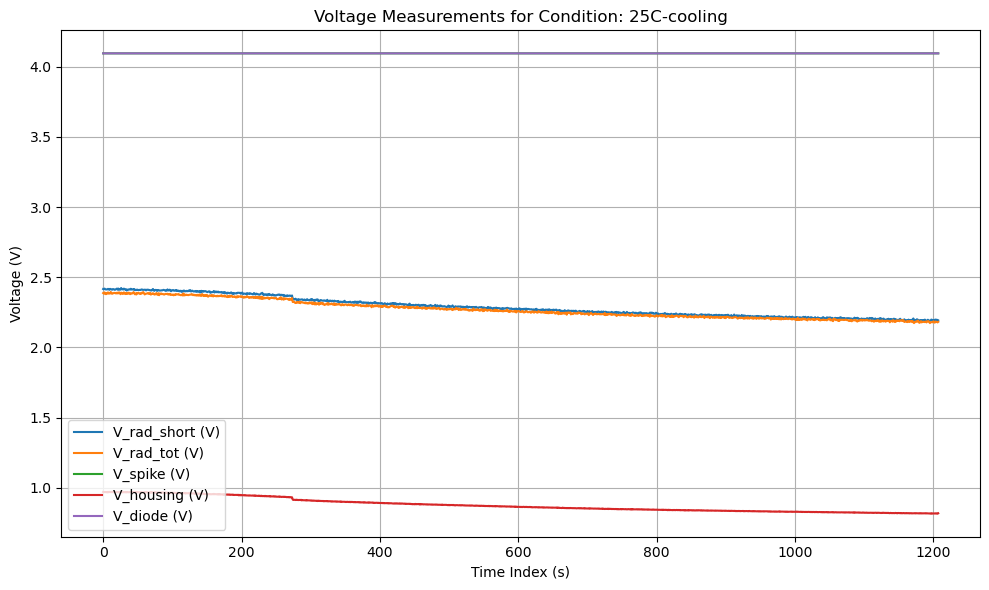

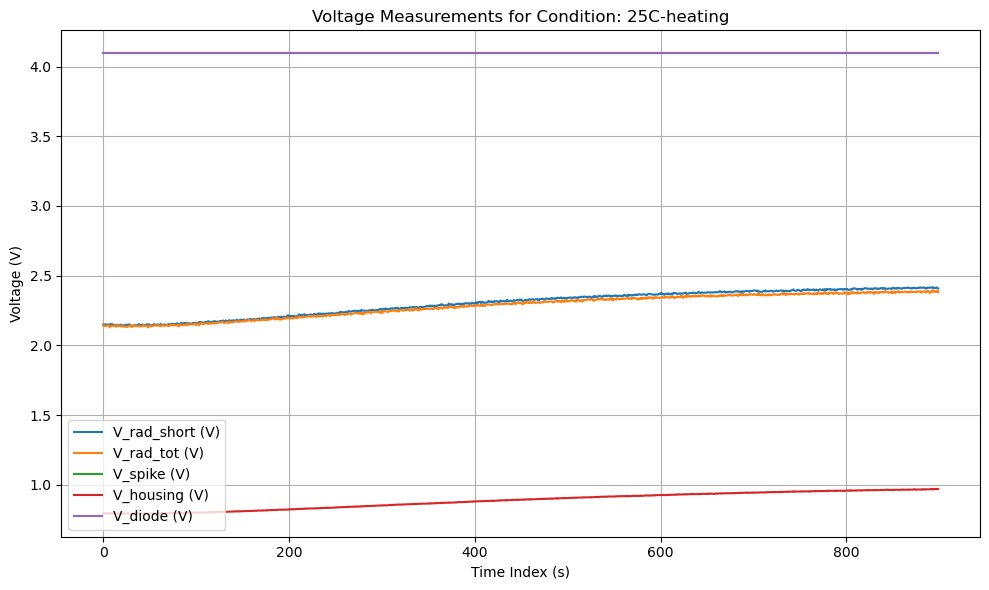

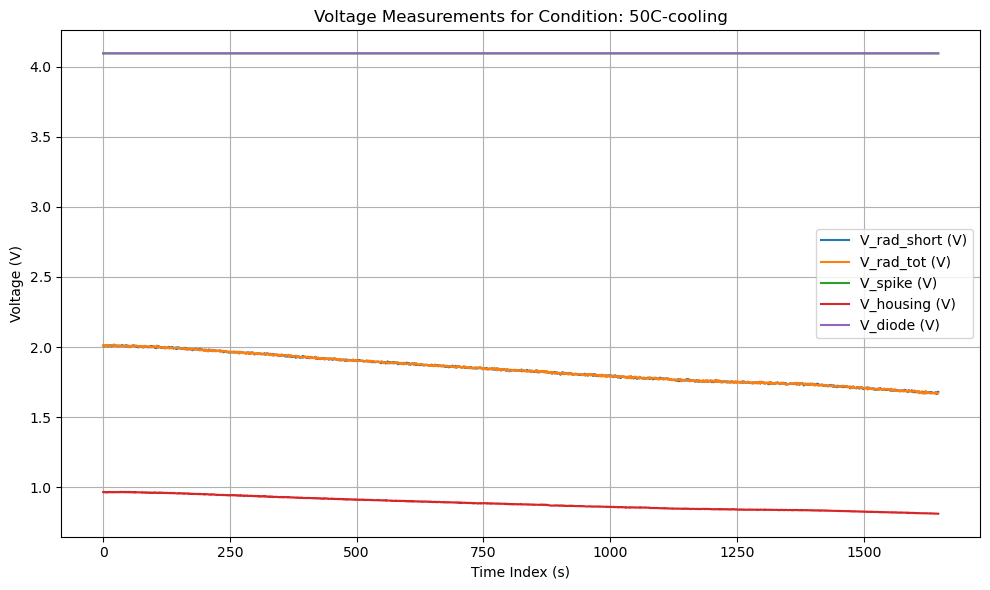

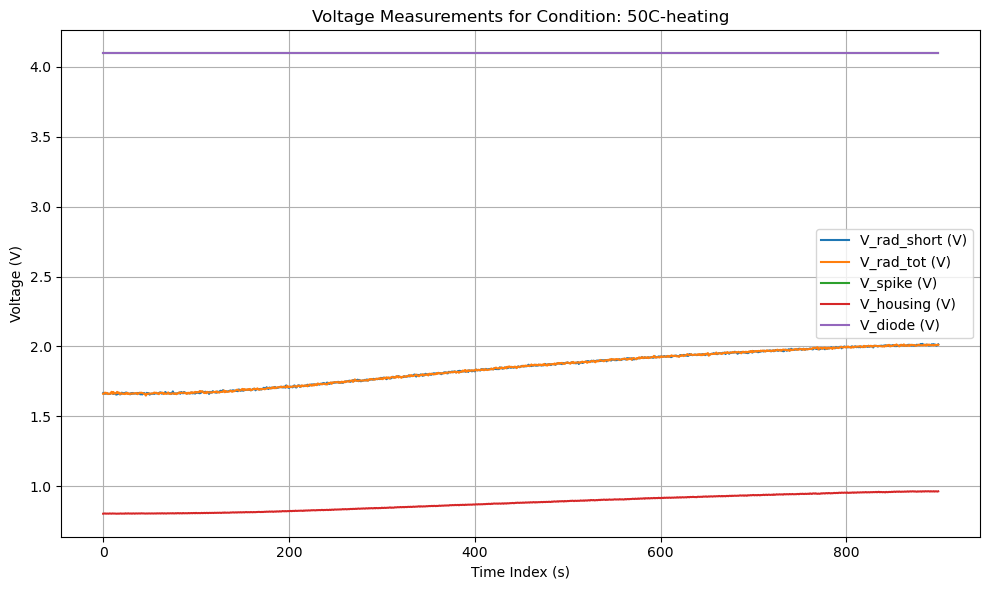

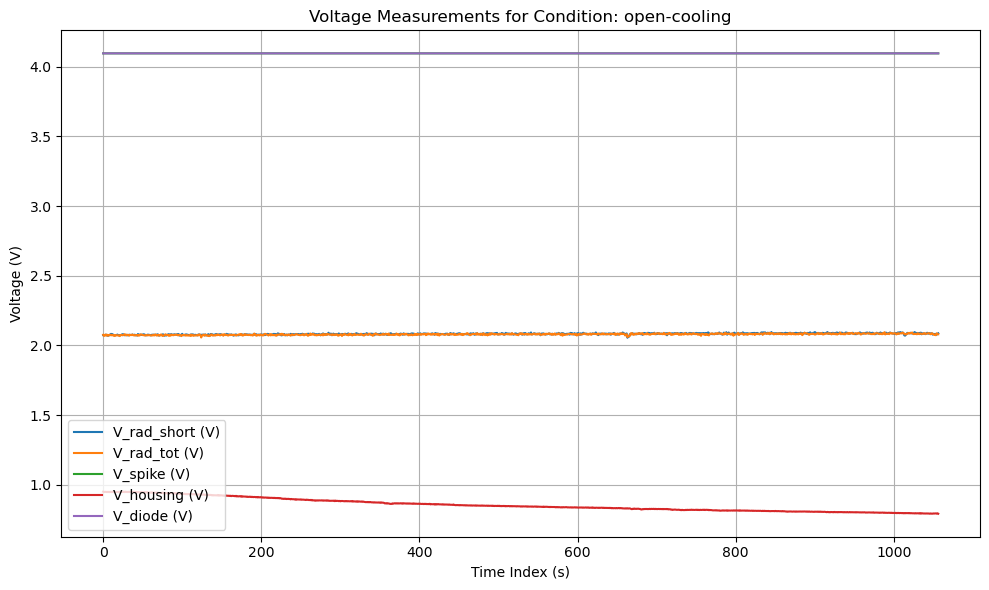

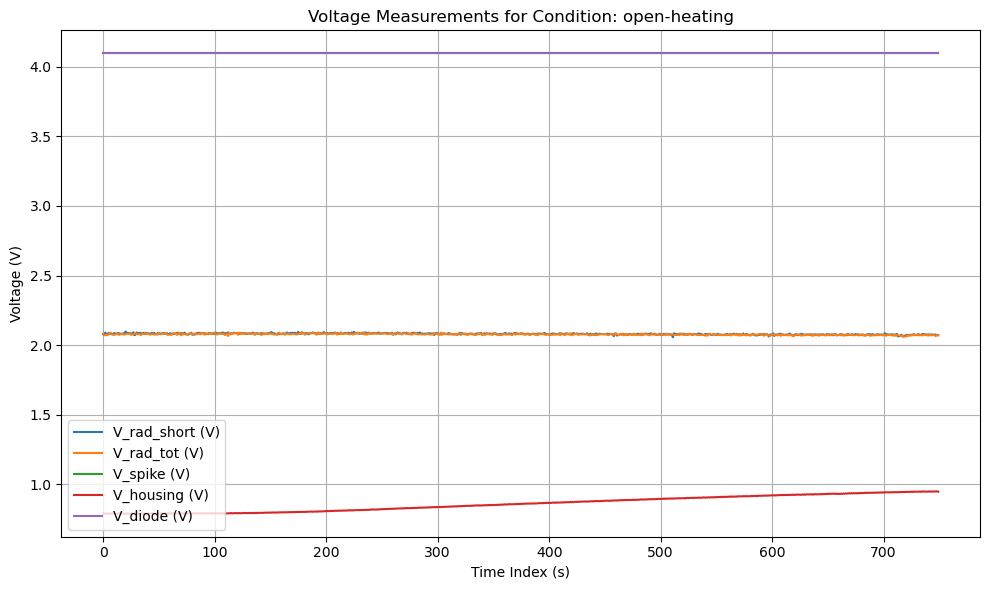

In [170]:
# Plot V_rad_short, V_rad_tot, V_spike, V_housing, V_diode vs sample index for each condition

variables = ['V_rad_short', 'V_rad_tot', 'V_spike', 'V_housing', 'V_diode']
labels = {
    'V_rad_short': 'V_rad_short (V)',
    'V_rad_tot': 'V_rad_tot (V)',
    'V_spike': 'V_spike (V)',
    'V_housing': 'V_housing (V)',
    'V_diode': 'V_diode (V)'
}

for cond in sorted(all_X_renamed['condition'].unique()):
    subset = all_X_renamed[all_X_renamed['condition'] == cond].sort_values(by='time_index')
    plt.figure(figsize=(10, 6))
    for var in variables:
        plt.plot(subset.time_index, subset[var] / 1000, label=labels[var])
    plt.title(f"Voltage Measurements for Condition: {cond}")
    plt.xlabel("Time Index (s)")
    plt.ylabel("Voltage (V)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [176]:
all_X = all_X_renamed[~all_X_renamed.condition.isin(['open-heating', 'open-cooling'])]


# Radiometer Calibration

In [177]:
# Save the intercept and slope from the OPEN condition linear regression
open_slope = slope_open
open_intercept = intercept_open

def derive_t_housing_from_v_housing(v_housing):
    """
    Derive T_housing from V_housing using the OPEN condition linear regression.
    """
    return open_slope * v_housing + open_intercept

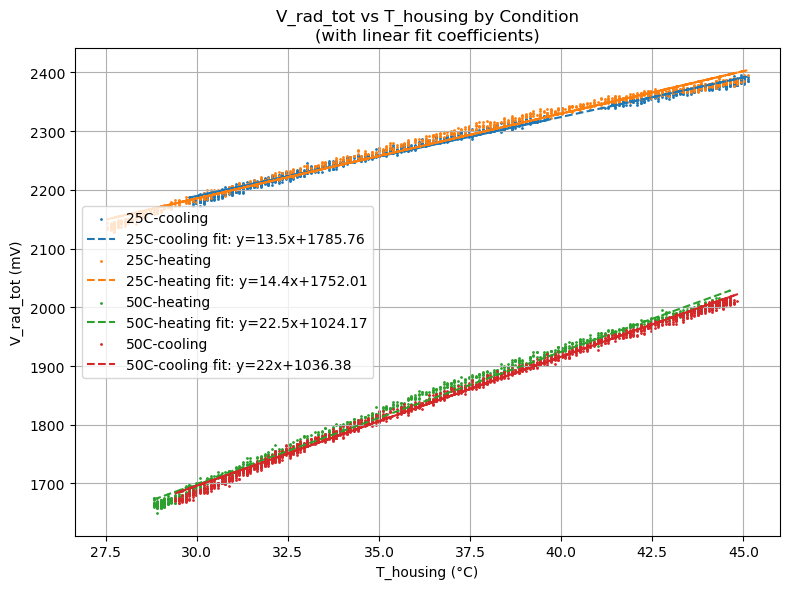

In [184]:
plt.figure(figsize=(8, 6))
for cond in all_X['condition'].unique():
    if cond == 'open':
        continue
    subset = all_X[all_X['condition'] == cond]
    # Calculate T_housing using the calibration function
    T_housing = derive_t_housing_from_v_housing(subset['V_housing'])
    # Plot V_rad_tot vs T_housing with smaller dots (no -2000 subtraction)
    plt.scatter(T_housing, subset['V_rad_tot'], label=cond, color=colors.get(cond, None), s=1)
    # Linear regression for this condition
    x_curve = T_housing.values.reshape(-1, 1)
    y_curve = subset['V_rad_tot'].values
    if len(x_curve) > 1:
        model_curve = LinearRegression()
        model_curve.fit(x_curve, y_curve)
        slope_curve = model_curve.coef_[0]
        intercept_curve = model_curve.intercept_
        plt.plot(T_housing, model_curve.predict(x_curve), color=colors.get(cond, None), linestyle='--',
                 label=f"{cond} fit: y={slope_curve:.3g}x+{intercept_curve:.2f}")
plt.xlabel('T_housing (°C)')
plt.ylabel('V_rad_tot (mV)')
plt.title('V_rad_tot vs T_housing by Condition\n(with linear fit coefficients)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [189]:
all_X = all_X[all_X.condition.str.contains("heating")]
# Generate cond_25 and cond_50 DataFrames from all_X
cond_25 = all_X[all_X['condition'] == '25C-heating']
cond_50 = all_X[all_X['condition'] == '50C-heating']

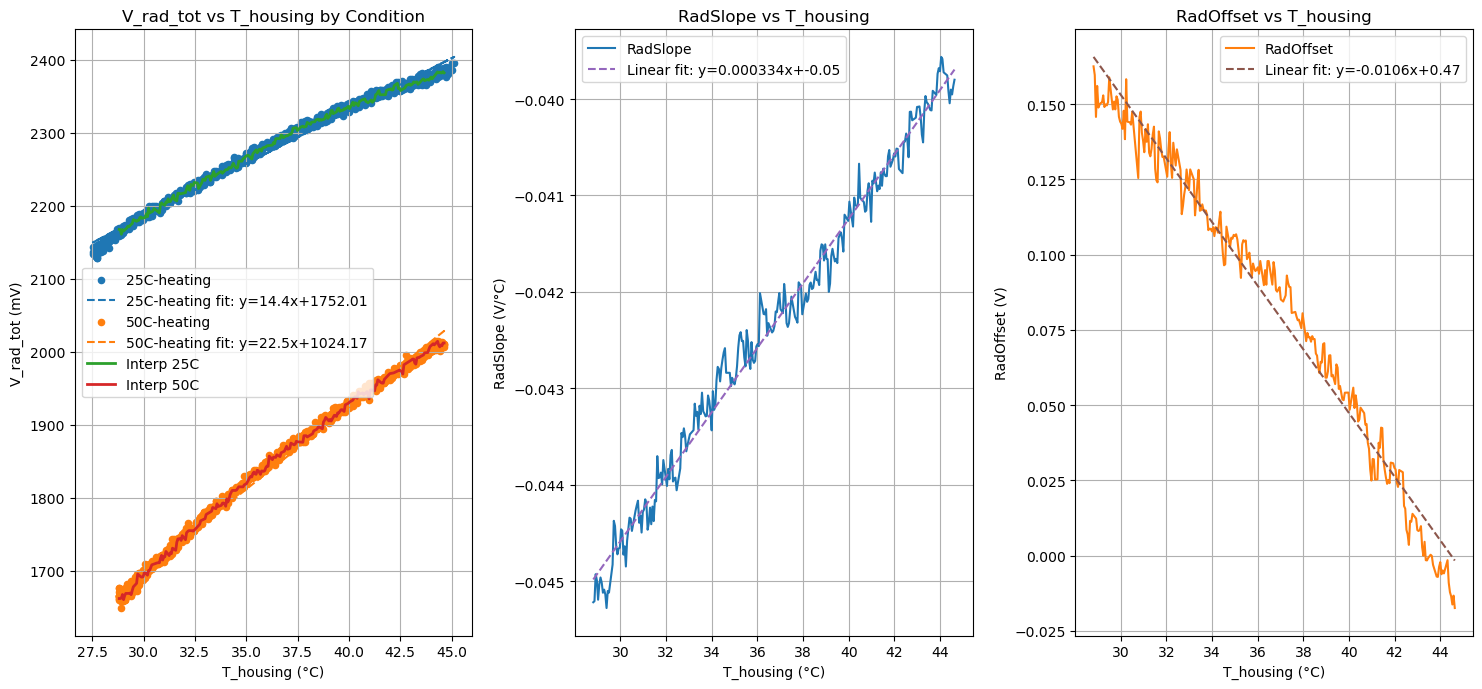

In [190]:

# Calculate shared T_housing range between 25C and 50C conditions with 300 points
T_25 = derive_t_housing_from_v_housing(cond_25['V_housing'])
T_50 = derive_t_housing_from_v_housing(cond_50['V_housing'])

T_min = max(T_25.min(), T_50.min())
T_max = min(T_25.max(), T_50.max())
T_shared = np.linspace(T_min, T_max, 300)

# Interpolate V_rad_tot for both conditions at shared T_housing
V_25_interp = np.interp(T_shared, T_25, cond_25['V_rad_tot'].values)
V_50_interp = np.interp(T_shared, T_50, cond_50['V_rad_tot'].values)

# Calculate RadSlope and RadOffset for each shared temperature
RadSlope = (2*(V_50_interp - V_25_interp) / 50-25) * 1e-3  # Convert to V/°C
RadOffset = - (25 - T_shared) * RadSlope + 2 * V_25_interp / 1000 - 4  # Offset at 25C, covert to V

# Linear regression for RadSlope vs T_housing
model_rs = LinearRegression()
model_rs.fit(T_shared.reshape(-1, 1), RadSlope)
rs_slope = model_rs.coef_[0]
rs_intercept = model_rs.intercept_

# Linear regression for RadOffset vs T_housing
model_ro = LinearRegression()
model_ro.fit(T_shared.reshape(-1, 1), RadOffset)
ro_slope = model_ro.coef_[0]
ro_intercept = model_ro.intercept_

# Plot: previous plot, RadSlope, RadOffset
fig, axes = plt.subplots(1, 3, figsize=(15, 7))

# 1. Previous plot: V_rad_tot vs T_housing by Condition + interpolation
for cond in all_X['condition'].unique():
    if cond.lower() == 'open':
        continue
    subset = all_X[all_X['condition'] == cond]
    T_housing_cond = derive_t_housing_from_v_housing(subset['V_housing'])
    axes[0].scatter(T_housing_cond, subset['V_rad_tot'], label=cond, color=colors.get(cond, None), s=20)
    x_curve = T_housing_cond.values.reshape(-1, 1)
    y_curve = subset['V_rad_tot'].values
    if len(x_curve) > 1:
        model_curve = LinearRegression()
        model_curve.fit(x_curve, y_curve)
        slope_curve = model_curve.coef_[0]
        intercept_curve = model_curve.intercept_
        axes[0].plot(T_housing_cond, model_curve.predict(x_curve), color=colors.get(cond, None), linestyle='--',
                     label=f"{cond} fit: y={slope_curve:.3g}x+{intercept_curve:.2f}")
# Add interpolated curves
axes[0].plot(T_shared, V_25_interp, color='tab:green', linestyle='-', linewidth=2, label='Interp 25C')
axes[0].plot(T_shared, V_50_interp, color='tab:red', linestyle='-', linewidth=2, label='Interp 50C')
axes[0].set_xlabel('T_housing (°C)')
axes[0].set_ylabel('V_rad_tot (mV)')
axes[0].set_title('V_rad_tot vs T_housing by Condition')
axes[0].legend()
axes[0].grid(True)

# 2. RadSlope plot + regression
axes[1].plot(T_shared, RadSlope, color='tab:blue', label='RadSlope')
axes[1].plot(T_shared, model_rs.predict(T_shared.reshape(-1, 1)), color='tab:purple', linestyle='--',
             label=f'Linear fit: y={rs_slope:.3g}x+{rs_intercept:.2f}')
axes[1].set_xlabel('T_housing (°C)')
axes[1].set_ylabel('RadSlope (V/°C)')
axes[1].set_title('RadSlope vs T_housing')
axes[1].legend()
axes[1].grid(True)

# 3. RadOffset plot + regression
axes[2].plot(T_shared, RadOffset, color='tab:orange', label='RadOffset')
axes[2].plot(T_shared, model_ro.predict(T_shared.reshape(-1, 1)), color='tab:brown', linestyle='--',
             label=f'Linear fit: y={ro_slope:.3g}x+{ro_intercept:.2f}')
axes[2].set_xlabel('T_housing (°C)')
axes[2].set_ylabel('RadOffset (V)')
axes[2].set_title('RadOffset vs T_housing')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()